/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


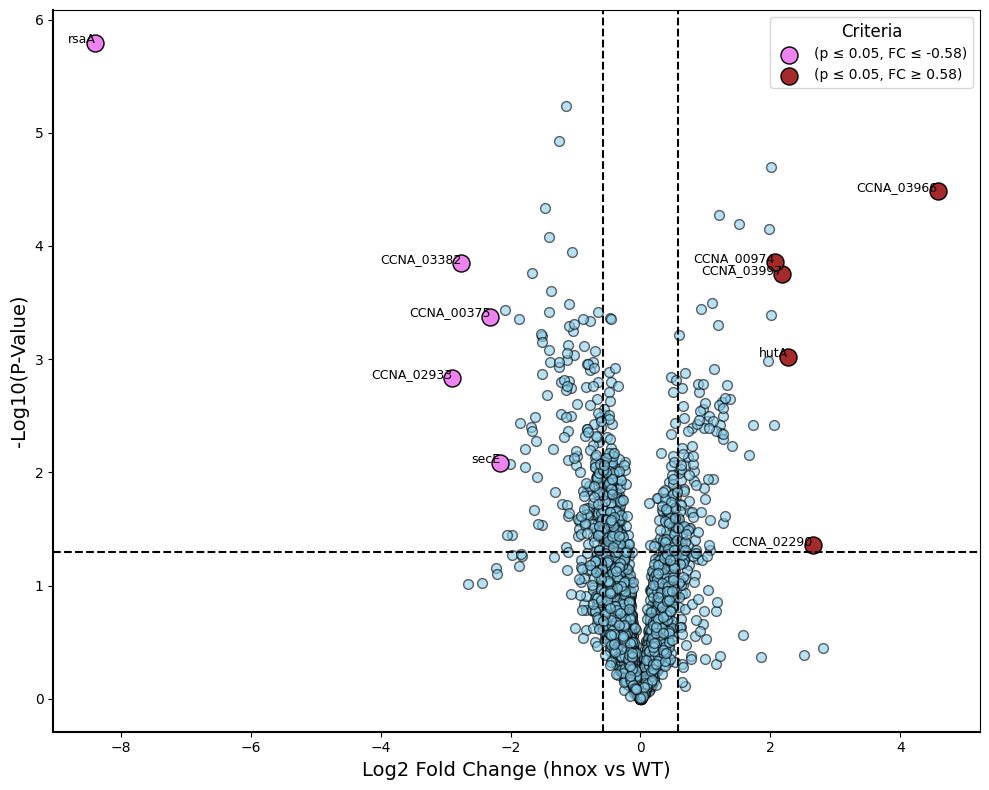

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/ikele218-stack/Python-Project-2/refs/heads/main/Exercise%2034%20copy.csv'
df = pd.read_csv(url)
df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[['Control_1', 'Control_2', 'Control_3']].mean(axis=1)
df['hnox_Mean'] = df[['KO_1', 'KO_2', 'KO_3']].mean(axis=1)

# Calculate log2 fold-change
df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['Control_1', 'Control_2', 'Control_3']].values,
    df[['KO_1', 'KO_2', 'KO_3']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for genes that meet significance criteria for fold change and p-value
significant_downregulated = df[(df['P_Value'] < p_threshold) & (df['Log2_FC'] < -fc_threshold)]
significant_upregulated = df[(df['P_Value'] < p_threshold) & (df['Log2_FC'] > fc_threshold)]

# Get the top 5 most down-regulated and top 5 most up-regulated significant genes
top_5_downregulated = significant_downregulated.sort_values(by='Log2_FC', ascending=True).head(5)
top_5_upregulated = significant_upregulated.sort_values(by='Log2_FC', ascending=False).head(5)

# Concatenate them to label them on the plot
top_genes = pd.concat([top_5_downregulated, top_5_upregulated])

# Separate significant genes for coloring (using the refined top 5 lists)
left_candidates = top_5_downregulated
right_candidates = top_5_upregulated


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='violet', s=150, edgecolor='black', marker='o', label='(p ≤ 0.05, FC ≤ -0.58)')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='brown', s=150, edgecolor='black', marker='o', label='(p ≤ 0.05, FC ≥ 0.58)')

# Add gene labels
for _, row in top_5_downregulated.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene Name'], fontsize=9, ha='right')
# Add gene labels
for _, row in top_5_upregulated.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene Name'], fontsize=9, ha='right')


# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (hnox vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()